The [Themis](https://dromotherm.github.io/documentation/Themis_overview.html) realtime monitoring machine, using the [emonCMS](https://github.com/emoncms/emoncms) opensource software, has been successfully used to collect datasets from the field. From June 2018 to august 2019, using a Themis machine, Cerema has monitored 3 single-family homes with electric heating, compiling a set of [feeds](https://raw.githubusercontent.com/alexandrecuer/smartgrid/master/datasets/emoncms-backup-2019-08-19.tar.gz) with meteorological, energy and thermal comfort datas.

Themis uses a specific timeserie named PHPFina. To operate this timeserie with packages like Numpy and TensorFlow, two python classes have been designed : PHPFina and BuildingZone, plus an external method named GoToTensor

- The PHPFina class permits to sample the PHPFina hexadecimal timeseries
- The GoToTensor method permits to create a numpy array/tensor from the samples
- The BuildingZone class creates and stores the datasets and implements fitting and prediction using a basic multinear approach and/or a LSTM (Long Short Term Memory) neural network

The structure of a tensor produced by the GoTotensor method is :

- tensor[:,0] = outdoor temperature values (at the step)
- tensor[:,1] = indoor temperature values (at the step)
- tensor[:,2] = energy consumptions (for the step to come) in kwh

Given an array of indexes, the BuildingZone class constructs the datasets by slicing the tensor on a specified length

# check the datas and fit the models

Start by importing the libraries

**Caution :  dependancies are not only numpy/matplotlib**

**tensorflow, pandas and sklearn are also required !!**

In [1]:
%matplotlib inline
from src.modelstats import BuildingZone, GoToTensor
import numpy as np
import matplotlib.pylab as plt

Define some sizing parameters

In [2]:
# number of points per hour
nbptinh=1
# timestep in seconds
step=3600//nbptinh
# history size in step(s) for prediction
history_size=10
# size of prediction in step - keep 1 !!!
target_size=1

Create the tensors from the PHPFina feeds

In [3]:
params=[{"id":1,"action":"smp"},{"id":167,"action":"smp"},{"id":145,"action":"acc"}]
test=GoToTensor(params,step,1538640000,65*24*nbptinh)
train=GoToTensor(params,step,1544184000,51*24*nbptinh)


Vizualize the outdoor and indoor temperature feeds to appreciate the specificity of collected datas

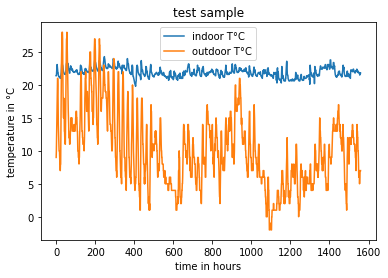

In [4]:
plt.title("test sample")
plt.ylabel("temperature in °C")
plt.xlabel("time in hours")
plt.plot(test[:,1], label="indoor T°C")
plt.plot(test[:,0], label="outdoor T°C")
plt.legend()
plt.show()

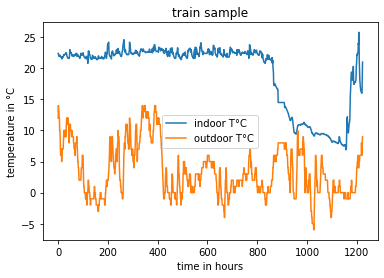

In [5]:
plt.title("train sample")
plt.ylabel("temperature in °C")
plt.xlabel("time in hours")
plt.plot(train[:,1], label="indoor T°C")
plt.plot(train[:,0], label="outdoor T°C")
plt.legend()
plt.show()

- The test sample is composed of 60 days on october and november 2018, at the beginning of winter
- The train sample is composed of 51 days on december 2018 and january 2019. 

The tenants left the house for something like 300 hours at the beginning of january, leaving the temperature decrease. We can see the temperature dropping from 20°C to something just above 5°C. The train sample is therefore more complete than the test sample as far as the phenomena we want to study is concerned : we can say it contains a real diversity of datas

We are now ready to create the building and to create the datasets

In [6]:
ite=BuildingZone(step,history_size,target_size)
ite.CalcMeanStd(train)
ite.AddSets(train, forTrain=True, shuffle=False)
ite.AddSets(test, forTrain=False)

[ 3.49754902 19.28316995  0.92602507]
[4.13201203 5.22732056 0.71683471]


we can proceed to the fitting operations with both the LSTM neural network and the multilinear approach. By default, the LSTMfit() method regularize the datas. To fit the multilinear model, regularization is not needed.  

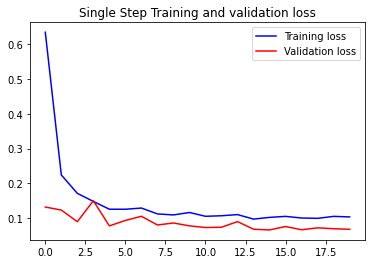

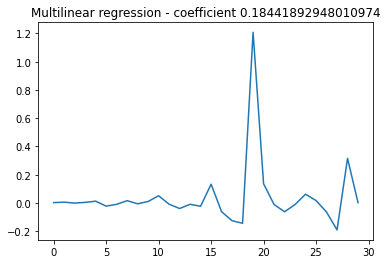

In [7]:
ite.LSTMfit("ite_no_shuffle")
ite.MLAfit(train, regularize=False)
ite.MLAviewWeights()

Validation losses with the LSTM neural network show no overfitting problem. 

# performance check

We can now vizualize the quality of the fitting by realizing some step by step indoor temperature predictions on the test dataset. To achieve this, we use the LSTMfit() and MLAfit() methods to produce the predictions and call the view() function to sketch a graphic output.

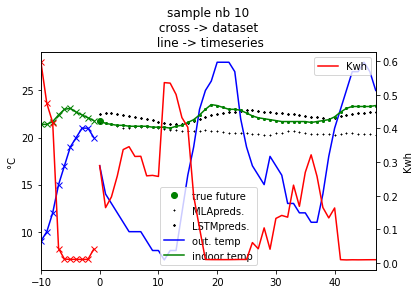

In [8]:
MLA_datas, MLA_labels = ite.MLAprepare(test)

def perfCheck(i,nbpreds,origTensor):
    LSTM_preds, LSTM_labels=ite.LSTMpredict(i,nbpreds)
    MLA_preds=ite.MLApredict(MLA_datas,i,nbpreds)
    ite.view(origTensor, i, nbpreds, MLApreds=MLA_preds, LSTMpreds=LSTM_preds,
                                                MLAtruths=MLA_labels[i:i+nbpreds], LSTMtruths=LSTM_labels)

perfCheck(0,48,test)

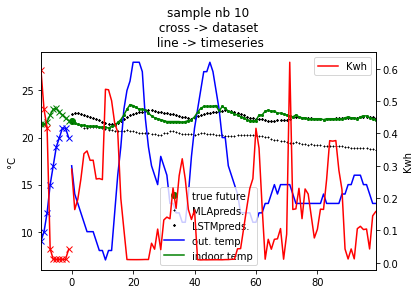

In [9]:
perfCheck(0,100,test)

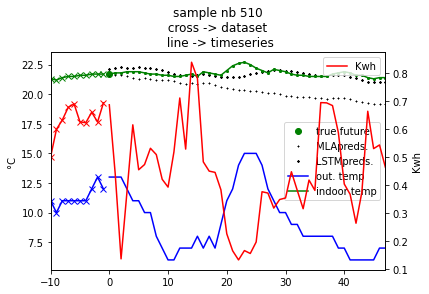

In [10]:
perfCheck(500,48,test)

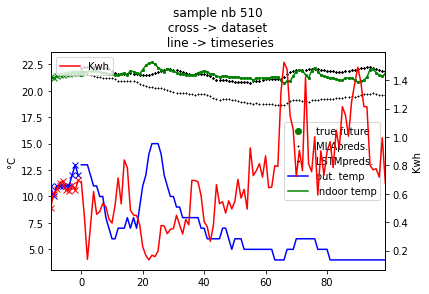

In [11]:
perfCheck(500,100,test)

The LSTM network seems to perform better. Let's check how things are going on some datas included in the train dataset.

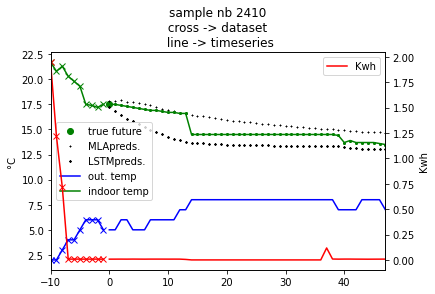

In [12]:
winter=GoToTensor(params,step,1538640000,150*24*nbptinh)
ite.ClearSets(train=False)
ite.AddSets(winter, forTrain=False)
MLA_datas, MLA_labels = ite.MLAprepare(winter)
perfCheck(2400,48,winter)

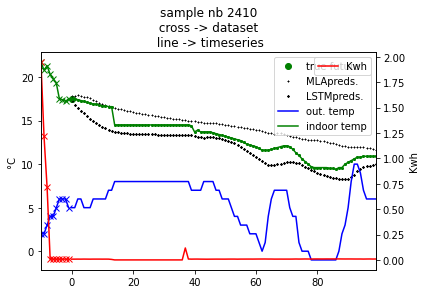

In [13]:
perfCheck(2400,100,winter)

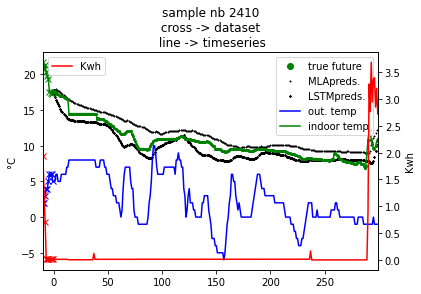

In [14]:
perfCheck(2400,300,winter)

On the training datas, performances of both approach (LSTM and multilinear) seem to be similar.